# Cross-Section Definition and Analysis

This notebook demonstrates how to define and analyze river cross-sections using RIVeR. We'll cover how to:
- Define cross-section lines using real-world coordinates
- Import and process bathymetry data 
- Calculate section properties like area and width
- Prepare cross-sections for velocity analysis

## Prerequisites

- Completed frame transformation (02b_oblique_transformation.ipynb)
- Bathymetry data for the river cross-sections
- Transformation matrix from previous steps

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
from tablib import Dataset

# Import RIVeR modules
from river.core.compute_section import (
    calculate_station_coordinates,
    divide_segment_to_dict,
    add_pixel_coordinates,
    calculate_river_section_properties
)
from river.core.coordinate_transform import transform_real_world_to_pixel

# Set up paths
frame_path = Path("data/frames/pisco/0000000004.jpg")
bath_file = Path("data/bathymetry/pisco_section.csv")
transformation_file = Path("results/pisco/transformation.json")
output_dir = Path("results/pisco")
output_dir.mkdir(parents=True, exist_ok=True)

## Step 1: Load Required Data

First, we'll load our transformation matrix and a sample frame to visualize the cross-sections. We'll also prepare to load bathymetry data.

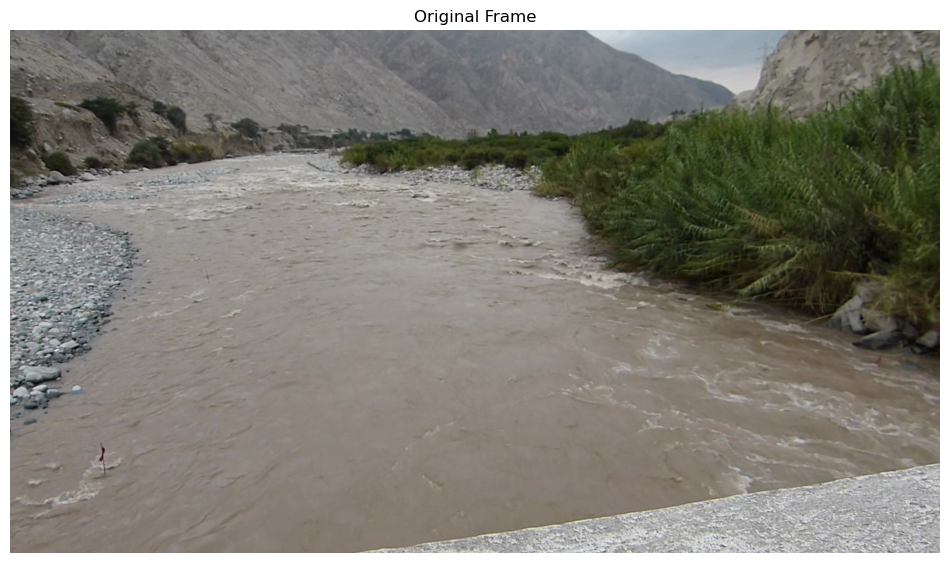

In [2]:
# Load transformation matrix
with open(transformation_file, 'r') as f:
    transformation_matrix = np.array(json.load(f))

# Load and display frame
frame = cv2.imread(str(frame_path))
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)
plt.axis('off')
plt.title('Original Frame')
plt.show()

## Step 2: Define Cross-Sections

We'll define one or more cross-sections using real-world coordinates (east, north). Each cross-section requires:
- Left bank coordinates (east_l, north_l)
- Right bank coordinates (east_r, north_r)
- Water level
- Number of stations
- Alpha coefficient (velocity correction factor)

In [3]:
# Define initial cross-sections dictionary
xsections = {
    "section1": {
        "east_l": -1.48,      # Left bank easting
        "north_l": 0.14,      # Left bank northing
        "east_r": 20.67,      # Right bank easting
        "north_r": 0.57,      # Right bank northing
        "level": 1.765,       # Water level
        "num_stations": 15,   # Number of analysis points
        "alpha": 1,           # Velocity correction coefficient
        "bath": str(bath_file),  # Path to bathymetry file
        "left_station": 2.0   # Offset for first station from left bank
    }
}

# Calculate pixel coordinates from real-world coordinates
left_pixel = transform_real_world_to_pixel(xsections["section1"]["east_l"], 
                                         xsections["section1"]["north_l"], 
                                         transformation_matrix)
right_pixel = transform_real_world_to_pixel(xsections["section1"]["east_r"], 
                                          xsections["section1"]["north_r"], 
                                          transformation_matrix)
# Calculate real-world length of the section
rw_length = np.sqrt((xsections["section1"]["east_r"] - xsections["section1"]["east_l"])**2 + 
                    (xsections["section1"]["north_r"] - xsections["section1"]["north_l"])**2)

# Update the dictionary with additional values
xsections["section1"].update({
    "xl": left_pixel[0],     # Left bank x-pixel coordinate
    "yl": left_pixel[1],     # Left bank y-pixel coordinate
    "xr": right_pixel[0],    # Right bank x-pixel coordinate
    "yr": right_pixel[1],    # Right bank y-pixel coordinate
    "rw_length": rw_length
})

# Save cross-sections to JSON
output_file = output_dir / "section.json"
with open(output_file, 'w') as f:
    json.dump(xsections, f, indent=2)
print(f"\nCross-sections data saved to {output_file}")


Cross-sections data saved to results/pisco/section.json


## Step 3: Visualize Cross-Section Location and Bathymetry

We'll create a side-by-side visualization to help understand the cross-section placement and its bathymetry profile:

Left panel:
- Shows the video frame with the cross-section location
- Red dot indicates the left bank point (xl, yl)
- Green dot indicates the right bank point (xr, yr)
- Orange line shows the cross-section path

Right panel:
- Shows the bathymetric profile of the river bed
- Black line represents the river bed elevation
- Blue dashed line shows the water level
- Blue shaded area represents the wetted cross-section

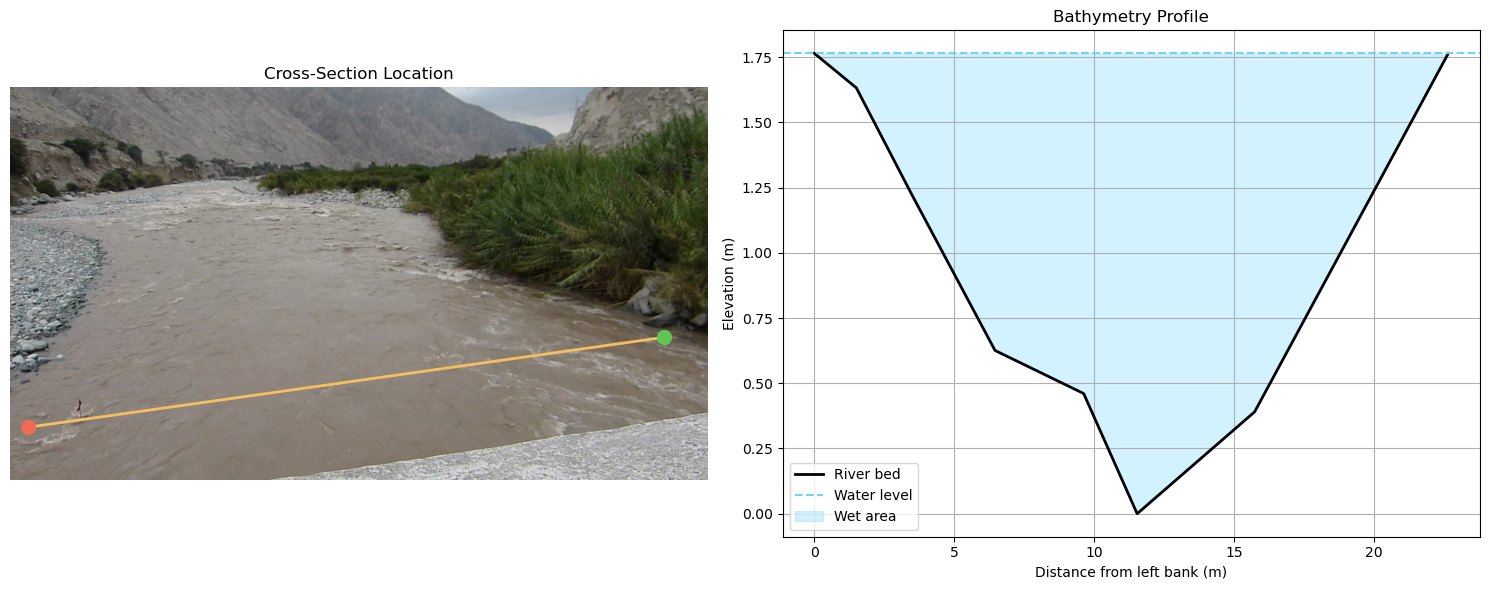

In [4]:
# Load and plot bathymetry data
data = Dataset()
with open(bath_file, 'r') as f:
    data.load(f, format='csv', headers=False)

# Extract stations and stages
stations = [float(i) if i is not None else 0.0 for i in data.get_col(0)[1:]]
stages = [float(i) if i is not None else 0.0 for i in data.get_col(1)[1:]]
stations = np.array(stations)
stages = np.array(stages)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# First subplot: Frame with cross-section points
ax1.imshow(frame_rgb)
ax1.plot([xsections["section1"]["xl"], xsections["section1"]["xr"]], 
         [xsections["section1"]["yl"], xsections["section1"]["yr"]], 
         color='#F5BF61', linewidth=2)  # Line connecting points
ax1.plot(xsections["section1"]["xl"], xsections["section1"]["yl"], 'o', color='#ED6B57', markersize=10)  # Left point
ax1.plot(xsections["section1"]["xr"], xsections["section1"]["yr"], 'o', color='#62C655', markersize=10)  # Right point

ax1.set_title('Cross-Section Location')
ax1.axis('off')

# Second subplot: Bathymetry profile
ax2.plot(stations, stages, 'k-', linewidth=2, label='River bed')
ax2.axhline(y=xsections["section1"]["level"], color='#6CD4FF', linestyle='--', label='Water level')
ax2.fill_between(stations, stages, xsections["section1"]["level"], 
                where=(stages <= xsections["section1"]["level"]), 
                alpha=0.3, color='#6CD4FF', label='Wet area')
ax2.grid(True)
ax2.set_xlabel('Distance from left bank (m)')
ax2.set_ylabel('Elevation (m)')
ax2.set_title('Bathymetry Profile')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()

## Step 4: Next Steps and Troubleshooting

### Next Steps
- Proceed to [04_piv_analysis.ipynb] where we will:
 - Configure PIV analysis parameters
 - Run velocity analysis for the defined cross-section

### Troubleshooting Common Issues

1. Cross-Section Definition:
  - Ensure left and right bank points are correctly ordered (left to right looking downstream)
  - Verify that real-world coordinates match your survey data
  - Check that the water level is above the minimum bed elevation and below the maximum bed elevation

2. Bathymetry Data:
  - Verify CSV format is correct (station, elevation columns)
  - Ensure stations increase from left to right bank
  - Check for missing or invalid elevation values
  - Confirm units match your coordinate system

3. Transformation Issues:
  - Double-check that transformation matrix is properly loaded
  - Verify pixel coordinates make sense on the image
  - Ensure real-world distances match field measurements

### Tips for Success
- Use multiple cross-sections for validation when possible